In [90]:
from oemof.solph import Model
from common import Districts
import pandas as pd
from oemof.solph import (EnergySystem, Bus, Sink, Source, Flow,
                         Transformer, GenericStorage)
from oemof.solph import views, processing
import matplotlib.pyplot as plt
import logging
from enum import Enum
import os
from os.path import join
import json
import warnings
from electricity_markets.market_price_generator import create_markets_info
import set_config
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.basicConfig(level=logging.INFO)


INFO:root:DA Price pattern for the year 2019 created
INFO:root:ID Price pattern for the year 2019 created
INFO:root:Electricity market prices (DA,ID,FB,FP) for 2019 created


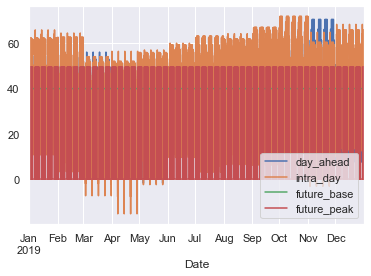

In [91]:
# Get market data as per the price generator
year = 2019
days = 365
RANGE = 24*4*365  # test a week
GAS_PRICE = 3.66  # EUR per mmBTU
# EUR/mmBTU / (293.07 kWh/mmBTU)
GAS_PRICE = GAS_PRICE / 293.07  # DELETE THE DIVISION TO 100
# a very oversized prize so buying from electricity is extremily discouraged
# works now with "regular" energy prices
ELEC_PRICE = 0.55
FACTOR_EE = 5
market_data = create_markets_info(
    year=year, save_csv=True,).head(
    days * 24 * 4)
market_data.plot()


def mlabel(txt, district=Districts.ENAQ):
    """Auxiliar function to create labels
    Args:
        txt (str): name of the element
        district : A district from the Districts Enum Class. Defaults to Districts.ENAQ.

    Returns:
        str: A string with the label and the district name
    """
    district_name = district.value["name"]
    label = district_name.lower()
    return f"{txt}_{label}"


In [92]:
def get_district_elements(district=Districts.ENAQ):
    """Creates an energy system and returns a list with all the elements.
    The elements can then be used to be aggregated in an integrated district.ENAQ
    Args:
        district: Defaults to Districts.ENAQ.
    """
    district_elements = []
    config = set_config.set_configuration(district=district)

    energy_system = EnergySystem(timeindex=config["datetime"][0:RANGE])

    # first need a "general electric bus"
    b_el_distr = Bus(label=mlabel("b_el_distr", district))

    # electric supply bus
    b_d_el = Bus(label=mlabel("b_d_el", district),
                 inputs={b_el_distr: Flow()})

    # this bus is to exchange energy with other districts:
    b_el_exch = Bus(label=mlabel("b_el_exch", district),
                    inputs={b_el_distr: Flow()})

    # add district demands
    d_el = Sink(label=mlabel("d_el", district),
                inputs={
                    b_d_el: Flow(
                        fix=config["el_demand"]["profile"][0:RANGE],
                        nominal_value=1)})
    energy_system.add(b_el_distr, b_d_el, b_el_exch, d_el)
    district_elements.extend([b_el_distr, b_d_el, b_el_exch, d_el])

    # add heat bus and district demand
    b_d_th = Bus(label=mlabel("b_d_th", district))
    # add district demands

    s_th = Sink(label=mlabel("s_th", district),
                inputs={b_d_th: Flow(fix=config["heat_demand"]["profile"][0:RANGE],
                        nominal_value=1)})
    energy_system.add(b_d_th, s_th)  # bus_th_distr
    district_elements.extend([b_d_th, s_th])

    # bus for selling electricity to the markets
    # and the 4 markets

    # this is the markets bus
    b_el_market = Bus(label=mlabel("b_el_market", district),
                      inputs={b_el_distr: Flow()})

    # Prices in EUR/kWh (need to divide by 4 since these are 15 mins intervals)
    s_day_ahead = Sink(label=mlabel("s_da", district), inputs={
        b_el_market: Flow(
            variable_costs=-
            market_data["day_ahead"][0:RANGE]/1000/4)})

    s_intraday = Sink(label=mlabel("s_id", district),
                      inputs={b_el_market: Flow(
                          variable_costs=-
                          market_data["intra_day"][0:RANGE]/1000/4)})

    s_f_base = Sink(
        label=mlabel("s_fb", district),
        inputs={
            b_el_market: Flow(
                variable_costs=-
                market_data["future_base"][0:RANGE]/1000/4)})

    s_f_peak = Sink(
        label=mlabel("s_fp", district),
        inputs={
            b_el_market: Flow(
                variable_costs=-
                market_data["future_peak"][0:RANGE]/1000/4)})

    energy_system.add(b_el_market, s_day_ahead, s_intraday, s_f_base, s_f_peak)
    district_elements.extend(
        [b_el_market, s_day_ahead, s_intraday, s_f_base, s_f_peak])


    # Add the external energy sources and related buses

    # external gas
    b_gas = Bus(label=mlabel("b_gas", district))
    energy_system.add(b_gas)
    district_elements.extend([b_gas])
    
    if "gas" in config.keys():
        s_gas = Source(label=mlabel('m_gas', district), outputs={
            b_gas: Flow(variable_costs=GAS_PRICE)})  # EUR/kWh
        energy_system.add(s_gas)
        district_elements.extend([s_gas])
    
    b_ext_th = Bus(label=mlabel("b_ext_th", district))
    energy_system.add(b_ext_th)
    district_elements.extend([b_ext_th])

    if "ext_grid" in config.keys():
        s_ext_th = Source(label=mlabel('s_ext_th', district),
                          outputs={b_ext_th: Flow()})  # EUR/kWh
        energy_system.add(s_ext_th)
        district_elements.extend([s_ext_th])

    b_el_grid = Bus(label=mlabel("b_el_grid", district),
                    outputs={b_d_el: Flow()})
    s_el_grid = Source(label=mlabel("s_el_grid", district),
                       outputs={b_el_grid: Flow(variable_costs=ELEC_PRICE)})  # EUR/kWh

    energy_system.add(b_el_grid, s_el_grid)
    district_elements.extend([b_el_grid, s_el_grid])

    # add renewable energy buses and technologies

    b_el_renew = Bus(label=mlabel("b_el_renew", district))
    energy_system.add(b_el_renew)
    district_elements.extend([b_el_renew])
    
    if "PV" in config.keys():
        s_pv = Source(label=mlabel("s_pv", district),
                      outputs={b_el_renew: Flow(nominal_value=1, max=config["PV"]["profile"][0:RANGE]*FACTOR_EE)})
        energy_system.add(s_pv)
        district_elements.extend([s_pv])

    if "Wind" in config.keys():
        s_wind = Source(label=mlabel("s_wind", district),
                        outputs={b_el_renew: Flow(nominal_value=1, max=config["Wind"]["profile"][0:RANGE]*FACTOR_EE)})
        energy_system.add(s_wind)
        district_elements.extend([s_wind])

    # Thermal energy bus from renewables.
    b_th_renew = Bus(label=mlabel("b_th_renew", district))
    energy_system.add(b_th_renew)
    district_elements.extend([b_th_renew])

    if "ST" in config.keys():
        s_st = Source(
            label=mlabel("s_st", district),
            outputs={
                b_th_renew: Flow(
                    nominal_value=1,
                    max=config["ST"]["profile"][0:RANGE]*FACTOR_EE)})
        energy_system.add(s_st)
        district_elements.extend([s_st])

    # add combination technologies, like CHP
    b_el_prod = Bus(label=mlabel("b_el_prod", district), inputs={
                    b_el_renew: Flow()}, outputs={b_el_distr: Flow()})
    b_th_prod = Bus(label=mlabel("b_th_prod", district), inputs={
                    b_th_renew: Flow()},)  # outputs={b_th_distr: Flow()}
    energy_system.add(b_el_prod, b_th_prod)
    district_elements.extend([b_el_prod, b_th_prod])
    
    # add a boiler
    if "boiler" in config.keys():
        t_boiler = Transformer(
            label=mlabel('t_boiler', district),
            inputs={b_gas: Flow()},
            outputs={b_th_prod: Flow(nominal_value=config["boiler"]["p_kw"])},
            conversion_factors={b_gas: 1, b_th_prod: config["boiler"]["eff"]})
        energy_system.add(t_boiler)
        district_elements.extend([t_boiler])

    if "chp" in config.keys():
        t_chp = Transformer(
            label=mlabel('t_chp', district),
            inputs={b_gas: Flow()},
            outputs={b_el_prod: Flow(nominal_value=config["chp"]["p_kw_el"]),
                     b_th_prod: Flow(nominal_value=config["chp"]["p_kw_th"])},
            conversion_factors={b_el_prod: config["chp"]["eff_el"],
                                b_th_prod: config["chp"]["eff_th"]})
        energy_system.add(t_chp)
        district_elements.extend([t_chp])

    # Heat Pump
    if "heat_pump" in config.keys():
        t_hp = Transformer(
            label=mlabel('t_hp', district),
            inputs={b_el_prod: Flow()},
            outputs={b_th_prod: Flow(
                nominal_value=config["heat_pump"]["p_kw_th"])},
            conversion_factors={b_th_prod: config["heat_pump"]["cop"][0:RANGE]})
        energy_system.add(t_hp)
        district_elements.extend([t_hp])

    # att electric storage
    if "batt_sto" in config.keys():
        batt_sto = GenericStorage(
            label=mlabel('sto_batt', district),
            inputs={
                b_el_prod: Flow(nominal_value=config["batt_sto"]["charge_cap"])},
            outputs={
                b_el_prod: Flow(nominal_value=config["batt_sto"]["discharge_cap"])},
            loss_rate=config["batt_sto"]["loss_rate"],
            nominal_storage_capacity=config["batt_sto"]["capacity"],
            inflow_conversion_factor=config["batt_sto"]["charge_eff"],
            outflow_conversion_factor=config["batt_sto"]["disch_eff"],
            initial_storage_level=0,
            balanced=False)
        energy_system.add(batt_sto)
        district_elements.extend([batt_sto])

    # This needs to be fixed to work with volumes and heat insulation properties
    # Will find a better formulation later
    bus_th_distr = Bus(label=mlabel("b_th_distr", district), inputs={
                       b_th_prod: Flow(), b_ext_th: Flow()}, outputs={b_d_th: Flow()})
    energy_system.add(bus_th_distr)
    district_elements.extend([bus_th_distr])

    #Heat Storage
    #TODO A better model for heat storage needs to be build. This is so far a generic storage
    if "heat_sto" in config.keys():
        heat_sto = GenericStorage(
            label=mlabel('sto_heat', district),
            inputs={
                bus_th_distr: Flow(nominal_value=config["heat_sto"]["charge_cap"])},
            outputs={
                bus_th_distr: Flow(nominal_value=config["heat_sto"]["discharge_cap"])},
            loss_rate=config["heat_sto"]["loss_rate"],
            nominal_storage_capacity=config["heat_sto"]["capacity"],
            inflow_conversion_factor=config["heat_sto"]["charge_eff"],
            outflow_conversion_factor=config["heat_sto"]["disch_eff"],
            initial_storage_level=0,
            balanced=False)
        energy_system.add(heat_sto)
        district_elements.extend([heat_sto])
    return energy_system, district_elements, config["datetime"][0:RANGE]


In [93]:
'''
Build a pyomo Model and add constraints for the proper sinks
:param energy_system: Energy System with the appropiate markets.
'''
# Build model
from oemof.solph import Model
import pyomo.environ as po

energy_system_enaq, district_elements_enaq, timeindex = get_district_elements(
    district=Districts.ENAQ)
energy_system_q100, district_elements_q100, timeindex = get_district_elements(
    district=Districts.QUARREE100)
energy_system_sq50, district_elements_sq50, timeindex = get_district_elements(
    district=Districts.SQ50)

integrated_es = EnergySystem(timeindex=timeindex)

for x in district_elements_enaq:
    integrated_es.add(x)
for x in district_elements_q100:
    integrated_es.add(x)
for x in district_elements_sq50:
    integrated_es.add(x)

In [94]:
# output busses for exchange
district_out_ex_buses = []
district_in_ex_buses = []

all_ellements = district_elements_enaq + \
    district_elements_q100+district_elements_sq50

for x in all_ellements:
    if "b_el_ex" in x.label:
        district_out_ex_buses.append(x)

    if "b_el_grid" in x.label:
        district_in_ex_buses.append(x)

bus_exch = Bus(label="district_exchange_bus",
               inputs={x: Flow() for x in district_out_ex_buses},
               outputs={x: Flow() for x in district_in_ex_buses})

integrated_es.add(bus_exch)


In [95]:
model = Model(integrated_es)

In [96]:

for district in [Districts.ENAQ, Districts.QUARREE100, Districts.SQ50]:
    # Before anything I need the shape of the future_peak in the shape of 1
    # and 0
    # electric bus
    bus_el_out = [n for n in integrated_es.nodes if n.label ==
                  mlabel("b_el_market", district)][0]
    # check output
    key = [k for k in bus_el_out.outputs.keys() if "s_fp" in str(k)][0]
    future_base_flow_price = bus_el_out.outputs[key].variable_costs

    # Add Market Constraints

    # Constraint for the Day Ahead Market
    # i = inflow
    # o = outflow
    flows = {}
    for (i, o) in model.flows:
        if str(i) == mlabel("b_el_market", district) and str(o) == mlabel("s_da", district):
            flows[(i, o)] = model.flows[i, o]

    for (i, o) in flows:
        for t in model.TIMESTEPS:
            if t % 4 != 0:
                # ToDo: Change name to day_ahead
                limit_name = "day_ahead_{}={}_{}".format(
                    t, t - t % 4, district)
                setattr(model, limit_name, po.Constraint(
                    rule=(model.flow[i, o, t] - model.flow[i, o, t - t % 4] == 0)))

    # Constraint for the Future Peak
    flows = {}

    for (i, o) in model.flows:
        if str(i) == mlabel("b_el_market", district) and str(o) == mlabel("s_fb", district):
            flows[(i, o)] = model.flows[i, o]

    for (i, o) in flows:
        for t in model.TIMESTEPS:
            if t != 0:
                limit_name = "future_base_{}={}_{}".format(t, 0, district)
                setattr(model, limit_name, po.Constraint(
                    rule=(model.flow[i, o, t] - model.flow[i, o, 0] == 0)))

    # Constraint for the Future Base
    # what are the time steps for decision making?
    # I rather look at the shape of the cost of the flow to see
    # if the price is 0, then constraint is 0
    # if price is not 0, then the price is equal

    flows = {}
    for (i, o) in model.flows:
        if str(i) == mlabel("b_el_market", district) and str(o) == mlabel("s_fp", district):
            flows[(i, o)] = model.flows[i, o]

    times_future_base_constraint = [t for t in model.TIMESTEPS if abs(
        future_base_flow_price[t]) > 0.001]  # a small tolerance there

    for time_step in times_future_base_constraint[1:]:  # for each day
        # range = 12*4 #time steps for the constraint, 13 hrs after 8 am, until
        # 20:45
        # the last bit of the 13h is not included
        t0 = times_future_base_constraint[0]
        for (i, o) in flows:
            limit_name = "future_peak_{}={}_{}".format(time_step, t0, district)
            setattr(model, limit_name, po.Constraint(
                rule=(model.flow[i, o, t0] - model.flow[i, o, time_step] == 0)))

    times_fb_null = [
        t for t in model.TIMESTEPS if t not in times_future_base_constraint]
    for t in times_fb_null:
        limit_name = "future_peak_null_{}_{}".format(t, district)
        setattr(
            model,
            limit_name,
            po.Constraint(
                rule=(
                    model.flow[i, o, t] == 0)))


In [97]:
model.solve(solver="cbc",
            solve_kwargs={'tee': False},
            solver_io='lp',
            cmdline_options={'ratio': 0.1})
energy_system = model.es
if model.solver_results.Solver[0].Status != "ok":
    raise AssertionError("Solver did not converge. Stopping simulation")

energy_system.results['valid'] = True
energy_system.results['solve_and_write_data'] = processing.results(
    model)
energy_system.results['solve_and_write_data'] = views.convert_keys_to_strings(
    energy_system.results['solve_and_write_data'])
energy_system.results['meta'] = processing.meta_results(
    model)


INFO:root:Optimization successful...


In [98]:
results = energy_system.results['solve_and_write_data']
results_list = []
for k in results.keys():
    if "flow" in list(results[k]['sequences'].keys()):
        flow = results[k]['sequences']['flow']
        if True:
            key_name = str(k)
            for s in [
                    "(", "'", ")"]:  # remove ( ' ) characters
                key_name = key_name.replace(s, "")
            flow.rename(key_name, inplace=True)
            flow_df = pd.DataFrame(flow)
            results_list.append(flow_df)

import datetime
now = datetime.datetime.now()

current_time = now.strftime("%y%m%d%H%M%S")
results = pd.concat(results_list, axis=1)
results.to_csv(f"results_integrated_{current_time}.csv")
   

<AxesSubplot:>

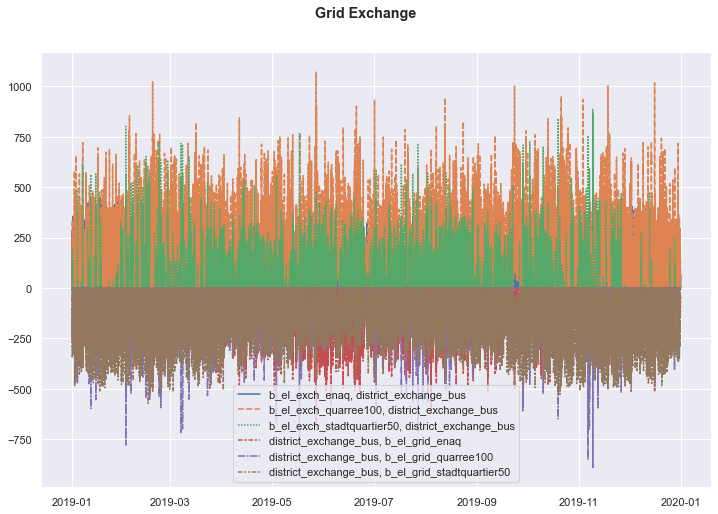

In [99]:
# CHP Results
cols = [c for c in results.columns if "district_exchange_bus" in c]
import seaborn as sns
sns.set()
#results[cols].plot(figsize=(12,8))
exchange = results[cols]
for c in exchange.columns:
    if "district_exchange_bus" in c.split(",")[0]:
        exchange[c]*=-1

fig,ax= plt.subplots(figsize=(12,8))
plt.suptitle("Grid Exchange", fontweight= "bold",y = 0.96)
palette = ["r","b","g","y"]
sns.lineplot(data=exchange, ax=ax)#, palette = palette)




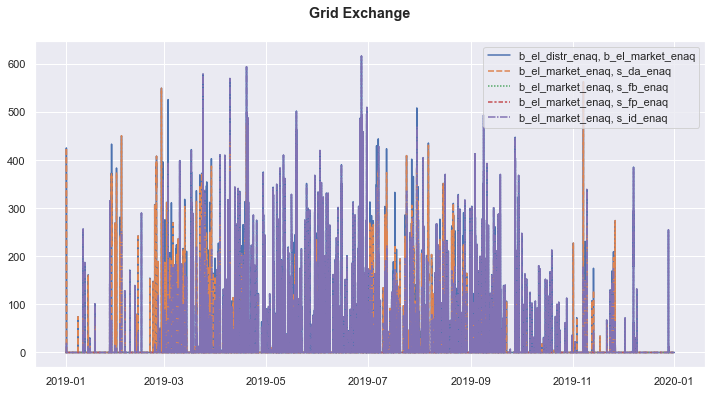

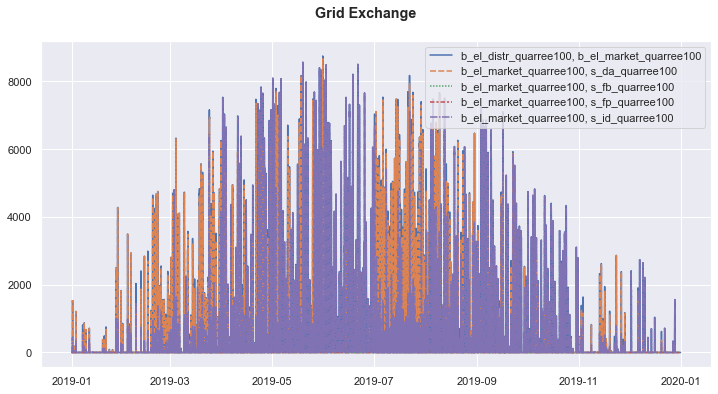

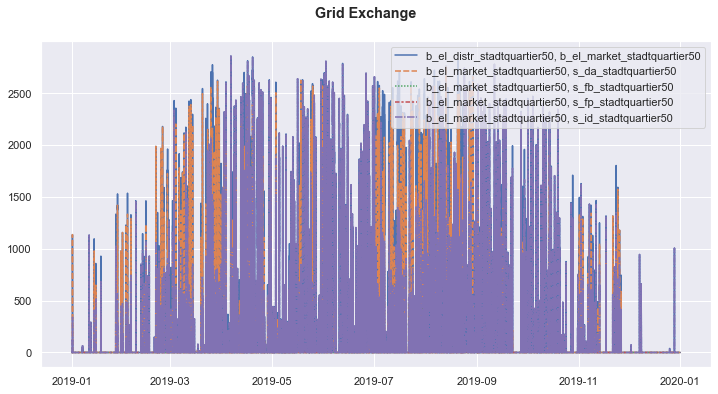

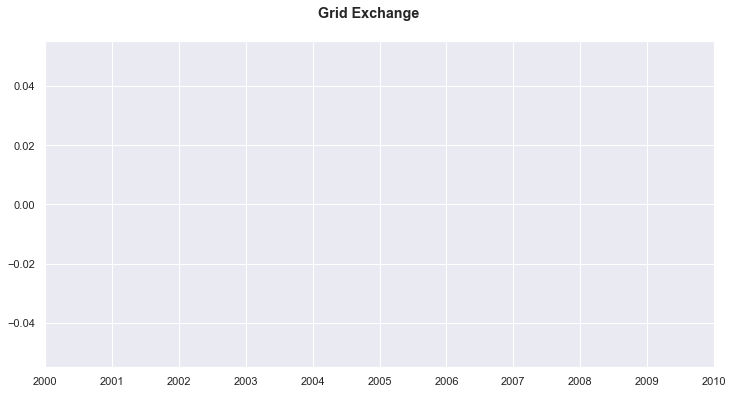

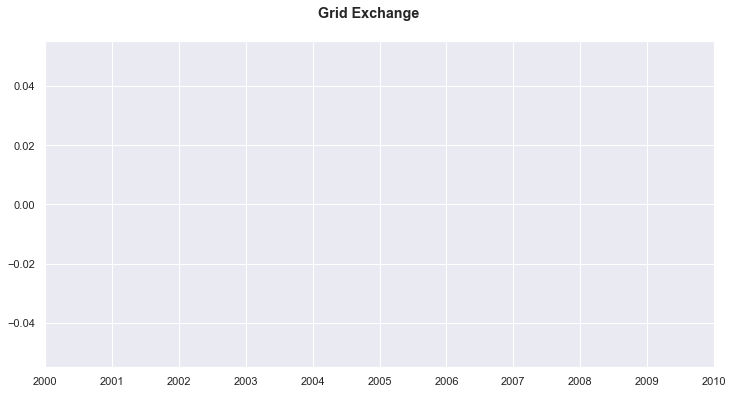

In [100]:
#markets:
for district in Districts:
    try:
        cols = [c for c in results.columns if mlabel("b_el_market",district) in c]
        fig,ax= plt.subplots(figsize=(12,6))
        plt.suptitle("Grid Exchange", fontweight= "bold",y = 0.96)
        sns.lineplot(data=results[cols], ax=ax)#, palette = palette)
    except:
        pass

<AxesSubplot:>

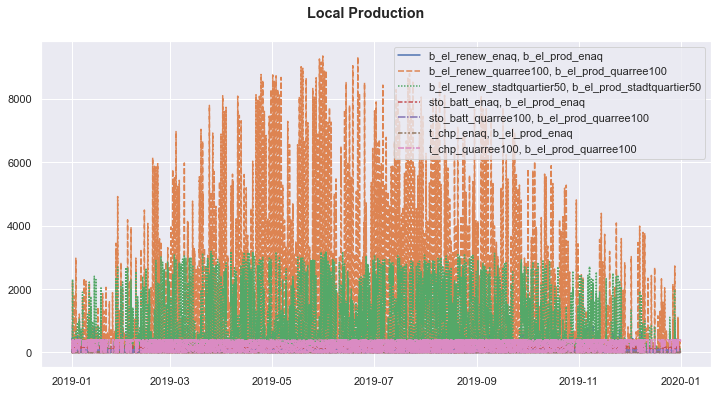

In [101]:
cols = [c for c in results.columns if "b_el_prod" in c.split(",")[1]]
fig,ax= plt.subplots(figsize=(12,6))
plt.suptitle("Local Production", fontweight= "bold",y = 0.96)
sns.lineplot(data=results[cols], ax=ax)#, palette = palette)


In [102]:
# Sum of the total energy flows from bus to bus
kpis = results.sum() / 4  # Since it it was in 15min intervals

# lables to fetch values from the dicts
for district in [Districts.ENAQ, Districts.QUARREE100, Districts.SQ50]:
    district_name = district.value["name"]
    district_name = district_name.lower()

    da = mlabel("s_da",district)
    id = mlabel("s_id",district)
    fb = mlabel("s_fb",district)
    fp = mlabel("s_fp",district)
    market = mlabel("b_el_market",district)
    distr = mlabel("b_el_distr",district)

    # Income 
    income = {
        f"income, da, {district_name}, EUR": results[f"{market}, {da}"].values * market_data["day_ahead"][0:RANGE].values,
        f"income, id, {district_name}, EUR": results[f"{market}, {id}"].values * market_data["intra_day"][0:RANGE].values,
        f"income, fb, {district_name}, EUR": results[f"{market}, {fb}"].values * market_data["future_base"][0:RANGE].values,
        f"income, fp, {district_name}, EUR": results[f"{market}, {fp}"].values * market_data["future_peak"][0:RANGE].values}

    income[f"income, total, {district_name}, EUR"] = income[ f"income, da, {district_name}, EUR"] + \
        income[ f"income, id, {district_name}, EUR"] + income[ f"income, fb, {district_name}, EUR"] + income[ f"income, fp, {district_name}, EUR"]

    income_total = {k: round(v.sum() / 4, 1) for k, v in income.items()}
    income_total[f"average_price {district_name}, EUR/MWh"] = income_total[f"income, total, {district_name}, EUR"] / \
        kpis[f"{distr}, {market}"]
    income_total = pd.Series(income_total)
    kpis=kpis.append(income_total)

    #expenses:
    # So far only two expenses are here: Gas (payed by kWh) and electricity (EUR/kWH)

    expenses = {
        f"expense, gas, {district_name}, EUR": results[f"{market}, {da}"].values * GAS_PRICE,
        f"expense, electricity, {district_name}, EUR": results[f"{market}, {id}"].values * ELEC_PRICE,}
    expenses_total = {k: round(v.sum() / 4, 1) for k, v in expenses.items()}
    expenses_total = pd.Series(expenses_total)
    kpis=kpis.append(expenses_total)



In [103]:
# operational hours
for district in [Districts.ENAQ, Districts.QUARREE100, Districts.SQ50]:
    district_name = district.value["name"]
    district_name = district_name.lower()
    pv = mlabel("s_pv",district)
    st = mlabel("s_st",district)
    wt = mlabel("s_wind",district)
    b_el_r = mlabel("b_el_renew",district)
    b_th_r = mlabel("b_th_renew",district)
    b_el_p = mlabel("b_el_prod",district)
    b_th_p = mlabel("b_th_prod",district)
    chp = mlabel("t_chp",district)
    hp = mlabel("t_hp",district)


    op_hours = {}
    if f"{pv}, {b_el_r}" in results.columns:
        op_hours[f"hours, PV, {district_name}"]= results[f"{pv}, {b_el_r}"].values
    if f"{wt}, {b_el_r}" in results.columns:
        op_hours[f"hours, WT, {district_name}"]= results[f"{wt}, {b_el_r}"].values 
    if f"{st}, {b_th_r}" in results.columns:
        op_hours[f"hours, ST, {district_name}"]= results[f"{st}, {b_th_r}"].values 
    if f"{chp}, {b_el_p}" in results.columns:
        op_hours[f"hours, CHP, {district_name}"]= results[f"{chp}, {b_el_p}"].values
    if f"{hp}, {b_th_p}" in results.columns:
        op_hours[f"hours, HP, {district_name}"]= results[f"{hp}, {b_th_p}"].values 

    try:
        op_hours = {k: [1 if x >0 else 0 for x in v] for k, v in op_hours.items()}
        op_hours = {k: sum(v)/4 for k, v in op_hours.items()}
        op_hours = pd.Series(op_hours)
        kpis=kpis.append(op_hours)
    except:
        pass


In [104]:
# indicators for energy exchange
exchange_out = {} # Total amount sent from the distrcits to the copper plate
exchange_in = {} # Total amount input from the copper plate to the district
for district in [Districts.ENAQ, Districts.QUARREE100, Districts.SQ50]:
    district_name = district.value["name"]
    district_name = district_name.lower()
    b_el_exch = mlabel("b_el_exch",district)
    b_el_grid = mlabel("b_el_grid",district)
    exchange_out[f"{district_name}, network"] = results[f"{b_el_exch}, district_exchange_bus"].values
    exchange_in[f"network, {district_name}"] = results[f"district_exchange_bus, {b_el_grid}"].values


exch_out_total = {k: round(v.sum() / 4, 1) for k, v in exchange_out.items()}
exch_out_total["network input total"] = sum(list(exch_out_total.values()))
exch_out_total = pd.Series(exch_out_total)
kpis=kpis.append(exch_out_total)
exch_in_total = {k: round(v.sum() / 4, 1) for k, v in exchange_in.items()}
exch_in_total["network output total"] = sum(list(exch_in_total.values()))
exch_in_total = pd.Series(exch_in_total)
kpis=kpis.append(exch_in_total)


In [105]:

kpis.to_csv(f"kpis_integrated_districts.csv")


In [109]:
energy_system.dump(os.getcwd(),"IntegratedSystem.oemof")

'Attributes dumped to: d:\\Developer Workspace\\DistrictsNetwork\\model\\IntegratedSystem.oemof'